<a href="https://colab.research.google.com/github/JJOK97/core-project-study/blob/js%2Ftext-mining/jinseok/textmining/%EB%84%A4%EC%9D%B4%EB%B2%84%EC%98%81%ED%99%94%ED%8F%89%EC%A0%90%EB%A6%AC%EB%B7%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# 목표 설정
# 네이버 영화 리뷰 데이터셋을 이용해서 긍정/부정을 판별하는 분류기를 만들어보자.
# TF-IDF 방법을 이용해서 토큰화를 진행해보자.
# Konlpy 한국어 형태소 분석기를 이용해보자.
# 단어별 긍/부정 정보를 시각화

# 경로 확인
import os
print("현재 작업 경로:", os.getcwd())

# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기 - WSL 환경에 맞게 경로 수정
# 데이터 파일은 ~/projects/data 폴더에 있다고 가정
train = pd.read_csv('../data/ratings_train.csv', encoding='utf-8')
test = pd.read_csv('../data/ratings_test.csv', encoding='utf-8')

현재 작업 경로: /home/jsock/projects


In [8]:
# 데이터 확인
print("학습 데이터 미리보기:")
print(train.head())

print("\n테스트 데이터 미리보기:")
print(test.head())

# train df의 대한 정보를 확인해보자
print("\n학습 데이터 정보:")
train.info()

# test df도 확인
print("\n테스트 데이터 정보:")
test.info()

# 결측치 확인
print("\n결측치가 있는 행:")
print(train[train['document'].isnull()])

# .dropna : 결측치가 있는 행을 삭제해주는 함수
train.dropna(inplace=True)
test.dropna(inplace=True)

# 결측치 제거 후 데이터 확인
print("\n결측치 제거 후 학습 데이터 정보:")
train.info()

print("\n결측치 제거 후 테스트 데이터 정보:")
test.info()

학습 데이터 미리보기:
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1

테스트 데이터 미리보기:
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0

학습 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    N

In [9]:
# 문제 데이터와 정답 데이터 지정
x_train = train['document']  # 문제 데이터 (영화 리뷰)
x_test = test['document']    # 테스트 문제 데이터
y_train = train['label']     # 정답 데이터 (긍정/부정 라벨)
y_test = test['label']       # 테스트 정답 데이터

print("\n데이터 shape 확인:")
print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# TF-IDF 기법 사용
from sklearn.feature_extraction.text import TfidfVectorizer

# 한국어 형태소 분석기 불러오기
from konlpy.tag import Kkma

# 꼬꼬마 객체 생성
kkma = Kkma()

# 테스트용 예시 문장으로 형태소 분석 확인
example = "영화가 정말 재미있었어요"
print("\n형태소 분석 테스트:")
print(f"원문: {example}")
print(f"명사 추출: {kkma.nouns(example)}")
print(f"형태소 추출: {kkma.morphs(example)}")
print(f"품사 태그: {kkma.pos(example)}")


데이터 shape 확인:
x_train: (149995,), x_test: (49997,)
y_train: (149995,), y_test: (49997,)

형태소 분석 테스트:
원문: 영화가 정말 재미있었어요
명사 추출: ['영화']
형태소 추출: ['영화', '가', '정말', '재미있', '었', '어요']
품사 태그: [('영화', 'NNG'), ('가', 'JKS'), ('정말', 'MAG'), ('재미있', 'VA'), ('었', 'EPT'), ('어요', 'EFN')]


In [10]:
# tfidf + Kkma 명사 추출기 연결해서 사용
# 명사 추출기를 함수화
def myTokenizer(text):
    return kkma.nouns(text)

# 동사/형용사/보통명사만 추출하는 함수
def myTokenizer2(text):
    # 필요한 품사만 뽑아보기
    try:
        d = pd.DataFrame(kkma.pos(text), columns=['morph', 'tag'])
        
        # 인덱스를 태그로 지정
        d.set_index('tag', inplace=True)
        
        # 동사 / 형용사 / 보통명사만 뽑아서 문자열 리스트 반환
        if ('VV' in d.index) or ('VA' in d.index) or ('NNG' in d.index):
            # .values 대신 .tolist()를 사용하여 리스트 반환
            return d.loc[d.index.isin(['VV', 'VA', 'NNG'])]['morph'].tolist()
        else:
            return []
    except:
        return []  # 오류 발생 시 빈 리스트 반환

In [11]:
# 샘플 크기 설정 - 더 적은 데이터로 시작
sample_size = 500  # 처음에는 샘플 크기를 작게 설정

# TF-IDF Vectorizer에 연결
print("\n데이터 벡터화 시작...")
tfidf_final = TfidfVectorizer(tokenizer=myTokenizer2)

# 단어사전 구축 (샘플 데이터로)
tfidf_final.fit(x_train[:sample_size])

# 벡터화 (문서를 수치 벡터로 변환)
print("문서를 벡터로 변환 중...")
x_train_vec = tfidf_final.transform(x_train[:sample_size])
x_test_vec = tfidf_final.transform(x_test[:sample_size])

# 단어사전 크기 확인
vocab_size = len(tfidf_final.vocabulary_)
print(f"\n단어사전 크기: {vocab_size}개 단어")


데이터 벡터화 시작...


/home/jsock/datascience_env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


문서를 벡터로 변환 중...

단어사전 크기: 1628개 단어


In [12]:
# 로지스틱 회귀 모델 학습
from sklearn.linear_model import LogisticRegression
print("\n로지스틱 회귀 모델 학습 시작...")

# 로지스틱 회귀 객체 생성
logi = LogisticRegression(max_iter=1000)  # 반복 횟수 증가

# 모델 학습
logi.fit(x_train_vec, y_train[:sample_size])

# 모델 평가
train_score = logi.score(x_train_vec, y_train[:sample_size])
test_score = logi.score(x_test_vec, y_test[:sample_size])

print(f"학습 데이터 정확도: {train_score:.4f}")
print(f"테스트 데이터 정확도: {test_score:.4f}")


로지스틱 회귀 모델 학습 시작...
학습 데이터 정확도: 0.9520
테스트 데이터 정확도: 0.7140


In [13]:
# 예측 테스트
def predict_sentiment(text):
    # 텍스트 벡터화
    text_vec = tfidf_final.transform([text])
    # 예측
    prediction = logi.predict(text_vec)[0]
    sentiment = "긍정" if prediction == 1 else "부정"
    return sentiment

# 예시 문장으로 테스트
test_reviews = [
    "정말 재미있는 영화였어요!",
    "시간 낭비였습니다. 정말 별로예요.",
    "배우들의 연기가 너무 좋았습니다."
]

print("\n예측 테스트:")
for review in test_reviews:
    sentiment = predict_sentiment(review)
    print(f"리뷰: '{review}' -> 감성: {sentiment}")


예측 테스트:
리뷰: '정말 재미있는 영화였어요!' -> 감성: 긍정
리뷰: '시간 낭비였습니다. 정말 별로예요.' -> 감성: 부정
리뷰: '배우들의 연기가 너무 좋았습니다.' -> 감성: 긍정


In [14]:
# 사용자 리뷰 감성 분석
# 정답의 구조: 0(부정), 1(긍정)
review = [input('리뷰를 입력해 주세요 : ')]
target_names = ['부정', '긍정']  # 0번 인덱스 접근시 부정, 1번 인덱스 접근시 긍정

# 토큰화 변환 진행 (모델은 숫자벡터만 이해하기 때문)
vect_review = tfidf_final.transform(review)

# predict_proba
# 클래스에 대한 확률 반환 [0.2, 0.8]
pro = logi.predict_proba(vect_review)  # max() 값으로 더 큰값을 받아오면 -> 신뢰도

# predict
# 하나의 정답(0 또는 1) 반환
pre = logi.predict(vect_review)

print(f'{review[0]} 문장은 {pro.max()*100: .2f}%로 {target_names[pre[0]]} 리뷰입니다.')

# 단어사전 가져오기
vocabulary = tfidf_final.vocabulary_
print(f"단어사전 크기: {len(vocabulary)}개 단어")

# 단어사전 정리
from operator import index
voc = pd.DataFrame(tfidf_final.vocabulary_.keys(),
                  index=tfidf_final.vocabulary_.values(),
                  columns=['word'])

# 단어사전 상위 20개 확인
print("\n단어사전 상위 20개:")
display(voc.head(20))

리뷰를 입력해 주세요 :  22


22 문장은  51.07%로 부정 리뷰입니다.
단어사전 크기: 1628개 단어

단어사전 상위 20개:


,word
887,아
332,더빙
1359,짜증나
509,목소리
1618,흠
1506,포스터
619,보고
1012,영화
1309,줄
1029,오버


In [16]:
from sklearn.linear_model import LogisticRegression

# 모델 훈련 (X, y 길이 일치!)
model = LogisticRegression(max_iter=1000)
model.fit(x_train_vec, y_train[:sample_size])

# 단어 목록 추출
vocab = tfidf_final.get_feature_names_out()

# 가중치 데이터프레임 생성
learning_result = pd.DataFrame(model.coef_.T, index=vocab, columns=['w'])

# 정렬
learning_result = learning_result.sort_values(by='w')

# 부정/긍정 단어 추출
bad = learning_result.head(20)
good = learning_result.tail(20)
top20 = pd.concat([bad, good])

print(top20)


            w
없   -1.528701
재미없 -1.044672
하   -0.933072
실망  -0.873569
내용  -0.873382
돈   -0.873296
스토리 -0.735479
쓰레기 -0.734027
나오  -0.716290
무엇  -0.668544
최악  -0.665468
짜증  -0.642620
발   -0.622454
아깝  -0.621994
모르  -0.608189
짜증나 -0.596914
티비  -0.586240
끝나  -0.575305
낳   -0.551690
망   -0.548727
웃    0.556559
슬픔   0.559345
생각   0.578402
재    0.582256
인생   0.632036
아쉽   0.638030
영화   0.647404
느끼   0.669755
명작   0.758802
멋지   0.913536
슬프   0.915180
좋    0.936951
감동적  0.956112
괜찮   0.991118
드라마  1.003569
재미있  1.180498
있    1.187215
보    1.274137
최고   1.400241
재밌   1.819250


In [17]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') # 나눔 폰트 설정

In [18]:
# 마이너스 기호 사용
plt.rcParams['axes.unicode_minus'] = False

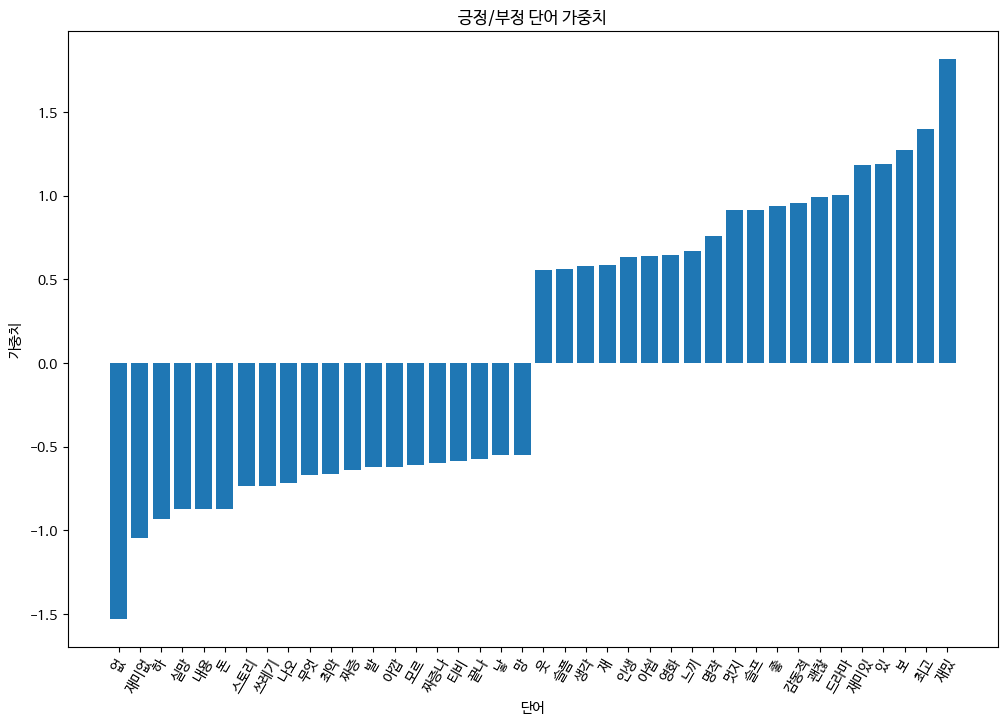

In [20]:
plt.figure(figsize=(12, 8))
plt.title('긍정/부정 단어 가중치')
plt.xlabel('단어')
plt.ylabel('가중치')

plt.bar(top20.index, top20['w'])
plt.xticks(rotation = 60)

plt.show()